__собираем статистики по объявлениям о аренде квартир__

_Evgeny S. Borisov <parser@mechanoid.su>_

In [1]:
!date

Пт 21 мар 2025 12:01:33 MSK


# загружаем данные

In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd

pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', '{:.2f}'.format)

In [3]:
# df = pd.read_pickle('data/2024/df_flat-arenda.pkl.gz')
df = pd.concat([
        pd.read_pickle('data/2024/df_flat-arenda.pkl.gz'),
        pd.read_pickle('data/2025/df_flat-arenda.pkl'),
    ]).reset_index(drop=True)
df['dt'] = df['ts'].dt.date
display( len(df) )
cols = ['title','address','latitude','longitude','priceM','dt']
display( df.sample(3)[cols] )

14550

,title,address,latitude,longitude,priceM,dt
4566,"1-к. квартира, 40 м², 3/5 эт.","севастополь,улица громова,52",44.630782,33.525809,0.02,2024-10-15
3768,"2-к. квартира, 58 м², 2/5 эт.","севастополь,проспект героев сталинграда,37",44.58868,33.441206,0.03,2024-12-16
4052,"1-к. квартира, 40 м², 2/10 эт.","севастополь,советская улица ,16",44.609282,33.524156,0.04,2024-12-16


In [4]:
df['priceK'] = df['price']/1_000

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14550 entries, 0 to 14549
Data columns (total 26 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   url            14550 non-null  object        
 1   place          14550 non-null  object        
 2   title          14550 non-null  object        
 3   price          14550 non-null  int64         
 4   address        14550 non-null  object        
 5   description    14550 non-null  object        
 6   ts             14550 non-null  datetime64[us]
 7   nrooms         14550 non-null  int64         
 8   floor          14550 non-null  int64         
 9   nfloors        14550 non-null  int64         
 10  area           14550 non-null  float64       
 11  is_studio      14550 non-null  bool          
 12  is_apartment   14550 non-null  bool          
 13  is_part        14550 non-null  bool          
 14  is_auction     14550 non-null  bool          
 15  is_openspace   1455

In [6]:
# только авито
display(len(df))
df = df[ ~df['url'].str.match(r'.*cian\.ru.*') ].reset_index(drop=True)
display(len(df)) 

14550

14550

In [7]:
# cols = ['title','address','latitude','longitude','priceM','dt','place','url']
# df[ (df['place']=='sevastopol') & (df['address'].str.match(r'.*Судак.*')) ][cols]

---

In [8]:
# df[ df['ts'].dt.date > pd.to_datetime('2024-01-01').date() ]

In [9]:
# df_ = pd.read_pickle('data/2023/data_flat.pkl').rename(columns={'adr':'address'})
# display( len(df_) )
# df_ = (
#         df_
#         .dropna(subset=['dt','url'])
#         .drop_duplicates(['dt','url'])
#         .drop(columns=['adr_orig','obj_name','avito_page','cian_page'])
#     )
# display( len(df_) )
# cols = ['title','address','latitude','longitude','priceM','dt','url']
# display( df_.sample(3)[cols] )

In [10]:
def address_filter(df):
    #           46.319437, 33.911048
    #
    # 45.402617, 32.455625 |  45.545301, 36.684702
    #
    #          44.320887, 33.917013

    df['latitude'] = pd.to_numeric( df['latitude'], errors='coerce' )
    df['longitude'] = pd.to_numeric( df['longitude'], errors='coerce' )

    df = df.query('(32.4<longitude<36.7) & (44.3<latitude<46.4)') 

#     df.loc[ df['url']=='https://avito.ru/2322251740', ['latitude','longitude']] = None

#     df.loc[ df['address']=='Севастополь,Чёрное море', ['latitude','longitude'] ] = None
#     df.loc[ df['address'].str.lower().str.match('чёрное море'), ['latitude','longitude'] ] = None 

#     df.loc[ df['address']=='квартал Старый Город', 'place'] = 'turkie'
#     df.loc[ df['address'].str.lower().str.match('анталья'), 'place' ] = 'turkie' 

#     df.loc[ df['address'].str.lower().str.match(r'.*бахчисарай.*'), 'place' ] = 'bahchisaray'
#     df.loc[ df['address'].str.lower().str.match(r'.*севастополь,.*'), 'place' ] = 'sevastopol'

#     df.loc[ df['address'].str.lower().str.match(r'.*мысовское.*'), 'place' ] = 'kerch'
#     df.loc[ df['address'].str.lower().str.match(r'.*алушта.*'), 'place' ] = 'alushta'
#     df.loc[ df['address'].str.lower().str.match(r'.*гурзуф.*'), 'place' ] = 'gurzuf'

#     df.loc[ df['address'].str.lower().str.match(r'.*с.лучистое.*'), 'place' ] = 'alushta'
#     df.loc[ df['address'].str.lower().str.match(r'.*снт солнечная долина.*'), 'place' ] = 'sudak'
#     df.loc[ df['address'].str.lower().str.match(r'.*пгт.новоозёрное.*'), 'place' ] = 'evpatoria'

#     df.loc[ df['address'].str.lower().str.match(r'.*с.мирное.*'), 'place' ] = 'simferopol'
#     df.loc[ df['address'].str.lower().str.match(r'.*тсн аэрофлот.*'), 'place' ] = 'simferopol'

#     df.loc[ df['address'].str.lower().str.match(r'.*семисот.*'), 'place' ] = 'kerch'

#     df.loc[ df['address'].str.lower().str.match(r'.*ялта.*') , 'place' ] = 'yalta'
#     df.loc[ df['address'].str.lower().str.match(r'.*феодосия.*') , 'place' ] = 'feodosia'
#     df.loc[ df['address'].str.lower().str.match(r'.*окуневка.*') , 'place' ] = 'tarkhankut'
#     df.loc[ df['address'].str.lower().str.match(r'.*заветное.*') , 'place' ] = 'kerch'
#     df.loc[ df['address'].str.lower().str.match(r'.*евпатория.*') , 'place' ] = 'evpatoria'
#     df.loc[ df['address'].str.lower().str.match(r'.*симферопольский район.*'), 'place' ] = 'simferopol'

#    df.loc[ df['address'].str.lower().str.match(r'.*c.симферопольский район.*'), 'place' ] = 'simferopol'

    df.loc[ df['address'].str.lower().str.match(r'.*судак,село радостное.*'), 'place' ] = 'st.krym'
    df = df.dropna(subset=['latitude','longitude'])
    
    return df

In [11]:
display( len(df) )
df = address_filter(df)
# history_date = df_['dt'].max()
# df = pd.concat([df,df_])
display( len(df) )
# del df_

14550

14550

----

In [12]:
df['month'] = df['ts'].dt.to_period('M')
df['week']  = df['ts'].dt.to_period('W')

In [13]:
display( len(df) )
df = df.drop_duplicates(subset=['week','url']).reset_index(drop=True)
display( len(df) )

14550

14550

In [14]:
# display( len(df) )
# df = df.dropna(subset=['latitude','longitude'])
# display( len(df) )

In [15]:
display( len(df) )
df = df.query('nrooms in (1,2,3)').reset_index(drop=True)
display( len(df) )

14550

11414

----

In [16]:
# display(len(df))
# # выкидываем "ущербные" варианты 
# df = df.query('~(is_studio|is_apartment|is_part|is_auction|is_openspace|is_SNT|is_roof)&(nrooms>0)&(nrooms<4)')
# display(len(df))
# df = df.query('priceM>1.') # выкидываем предожения с аномально низкой ценой
# display(len(df))

In [17]:
gdf = gpd.GeoDataFrame( df, geometry = gpd.points_from_xy( df['longitude'], df['latitude']), crs='epsg:4326', )
# [['title','address','latitude','longitude','priceM']] 
display( gdf.sample(3)[cols])

,title,address,latitude,longitude,priceM,dt
9921,"3-к. квартира, 60 м², 1/5 эт.","севастополь,костромская улица ,10",44.59,33.57,0.04,2025-01-20
4016,"1-к. квартира, 33 м², 2/5 эт.","севастополь,улица адмирала юмашева,16",44.59,33.46,0.03,2024-12-23
5858,"2-к. квартира, 60 м², 3/9 эт.","севастополь,улица горпищенко,145 к1",44.58,33.58,0.03,2024-11-18


---

In [18]:
dt_max = df['dt'].max()
dt_min = df['dt'].min()
# display( dt_min,history_date,dt_max )
print( dt_min,' : ',dt_max )

2024-10-15  :  2025-03-21


In [19]:
# gdf_history = gdf.query(f'dt <= @history_date')
# gdf = gdf.query(f'dt > @history_date')

In [20]:
# display( len(gdf_history) )
display( len(gdf) )

11414

In [21]:
display( len(gdf) )
gdf = (
    gdf
    .query("place in ('sevastopol','sudak')")
    # .drop_duplicates(['dt','url'])
    .drop_duplicates(['url','week'])
    .reset_index(drop=True)
)
display( len(gdf) )

11414

11414

In [22]:
# # display( gdf.columns )

# display( len(gdf) )
# gdf = gdf.drop_duplicates(['url','week'])
# display( len(gdf) )

In [23]:
# gdf.columns

In [24]:
# цена за квадратный метр (тыс.руб.)
# gdf['price_area_K'] = (gdf['price']/gdf['area'])/1_000

In [25]:
# gdf[ ~gdf['url'].str.match(r'.*cian\.ru.*') ] 

# общая статистика

In [26]:
# gdf[['title','address','priceM','geometry']].sample(1024).explore()

In [27]:
gdf.query('place=="sevastopol"')[['title','address','priceK','geometry']].sample(min(1024,len(gdf))).explore()

In [28]:
# gdf.query('place=="sudak"')[['title','address','priceM','geometry']].explore()

In [29]:
# gdf_last[ gdf_last['address'].str.match(r'.*долина роз.*') ][['title','address','priceM','geometry','url']].explore()

---

In [30]:
percentiles=[.01,.05,.1,.25,.5,.75,.9,.95]
stat = (
        gdf
        .groupby(['place','nrooms','week'])
#         .groupby(['place','nrooms','month'])
        ['priceK'].describe(percentiles=percentiles)
    )
    
display( stat )

count  mean    std   min    1%    5%  \
place      nrooms week                                                          
sevastopol 1      2024-10-14/2024-10-20 333.00 25.64   9.20  9.00 10.00 15.00   
                  2024-10-21/2024-10-27 325.00 26.53   9.08  9.00 10.00 15.00   
                  2024-10-28/2024-11-03 306.00 25.95   8.84  9.00 10.00 15.00   
                  2024-11-04/2024-11-10 334.00 26.23   8.84  9.00 12.33 17.00   
                  2024-11-11/2024-11-17 331.00 25.99   8.99  9.00 10.60 16.00   
                  2024-11-18/2024-11-24 363.00 26.23   8.94  9.00 10.00 16.00   
                  2024-11-25/2024-12-01 337.00 26.32   9.20  9.00 11.36 15.40   
                  2024-12-02/2024-12-08 334.00 25.95   9.07 10.00 11.00 15.00   
                  2024-12-09/2024-12-15 332.00 25.90   9.23 10.00 11.00 15.00   
                  2024-12-16/2024-12-22 310.00 25.41   9.15 10.00 12.00 15.00   
                  2024-12-23/2024-12-29 274.00 25.15   9.28 10.00 10.97 15.00   
                  2025-01-06/2025-01-12 244.00 25.89   9.72  9.90 12.43 15.00   
                  2025-01-13/2025-01-19 262.00 25.61   7.68  9.90 12.30 15.53   
                  2025-01-20/2025-01-26 281.00 25.47   7.50  9.90 11.80 15.00   
                  2025-01-27/2025-02-02 250.00 26.01   8.06  9.90 11.23 16.00   
                  2025-02-03/2025-02-09 272.00 25.52   7.24 10.00 11.78 16.00   
                  2025-02-10/2025-02-16 281.00 26.17   7.94 10.00 10.80 16.00   
                  2025-03-10/2025-03-16 224.00 26.41   7.63 10.00 12.23 17.00   
                  2025-03-17/2025-03-23 184.00 25.93   7.35 12.00 14.99 16.00   
           2      2024-10-14/2024-10-20 233.00 33.86  15.38 15.00 15.32 20.00   
                  2024-10-21/2024-10-27 234.00 33.72  14.93 15.00 17.33 20.00   
                  2024-10-28/2024-11-03 218.00 34.39  15.16 15.00 18.00 20.00   
                  2024-11-04/2024-11-10 228.00 37.02  16.87 15.00 17.27 20.00   
                  2024-11-11/2024-11-17 230.00 36.43  16.95 15.00 18.00 20.00   
                  2024-11-18/2024-11-24 279.00 36.71  15.59 14.00 18.00 20.00   
                  2024-11-25/2024-12-01 276.00 36.21  15.54 14.00 16.50 20.00   
                  2024-12-02/2024-12-08 275.00 36.51  15.71 14.00 19.74 20.00   
                  2024-12-09/2024-12-15 278.00 36.00  15.95 14.00 17.00 20.00   
                  2024-12-16/2024-12-22 244.00 35.00  14.28 14.00 17.43 20.00   
                  2024-12-23/2024-12-29 245.00 34.03  13.13 14.00 16.32 20.00   
                  2025-01-06/2025-01-12 215.00 35.52  14.17 14.00 17.14 20.00   
                  2025-01-13/2025-01-19 229.00 35.68  14.26 15.00 17.28 20.00   
                  2025-01-20/2025-01-26 208.00 35.62  14.80 16.00 17.00 20.00   
                  2025-01-27/2025-02-02 180.00 37.25  15.67 16.00 17.79 20.86   
                  2025-02-03/2025-02-09 172.00 36.52  16.36 16.00 16.71 20.00   
                  2025-02-10/2025-02-16 186.00 35.75  14.93 15.00 16.85 20.00   
                  2025-03-10/2025-03-16 172.00 39.21  19.55 12.00 17.00 21.55   
                  2025-03-17/2025-03-23 137.00 98.66 671.69 10.00 17.36 22.00   
           3      2024-10-14/2024-10-20 109.00 54.37  32.33  7.50 25.00 27.40   
                  2024-10-21/2024-10-27  95.00 55.08  32.45 25.00 26.88 30.00   
                  2024-10-28/2024-11-03  84.00 52.95  29.80 24.00 24.00 27.15   
                  2024-11-04/2024-11-10  90.00 54.09  30.09 18.00 23.34 26.00   
                  2024-11-11/2024-11-17  95.00 53.17  29.95 18.00 23.64 26.70   
                  2024-11-18/2024-11-24 113.00 48.99  21.48 18.00 24.12 26.60   
                  2024-11-25/2024-12-01 107.00 49.60  25.24 18.00 23.06 27.00   
                  2024-12-02/2024-12-08 105.00 49.40  25.49 18.00 22.04 25.00   
                  2024-12-09/2024-12-15  95.00 46.97  25.20 22.00 22.94 25.00   
                  2024-12-16/2024-12-22  82.00 47.47  24.82 23.00 23.00 

In [31]:
import matplotlib.pyplot as plt

cols = ['1%','10%','25%','50%','75%']
sizes = stat.reset_index()['nrooms'].unique()

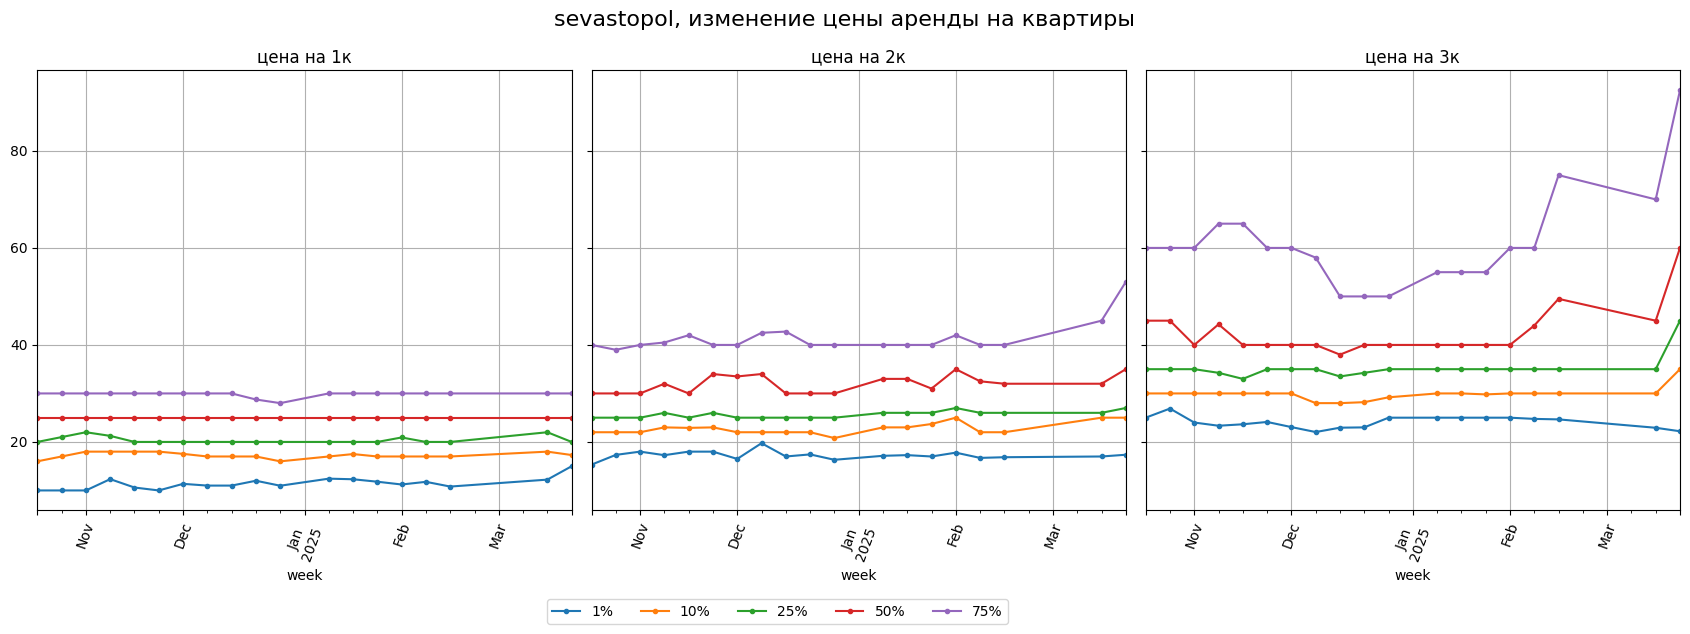

In [32]:
# history_date

place = 'sevastopol'

fig, ax = plt.subplots(1,len(sizes),figsize=(17,6), sharey=True )

for i,s in enumerate(sizes): 
    stat.loc[(place,s),cols].plot(title=f'цена на {s}к', grid=True,ax=ax[i],legend=False, rot=70, style='.-' )   
    #ax[i].set_yticks( np.arange(2, 16, step=1) )

fig.suptitle(f'{place}, изменение цены аренды на квартиры', fontsize=16)
fig.legend( labels=cols,frameon=True, ncol=len(cols), bbox_to_anchor=(0.6, 0.01))    
fig.tight_layout()

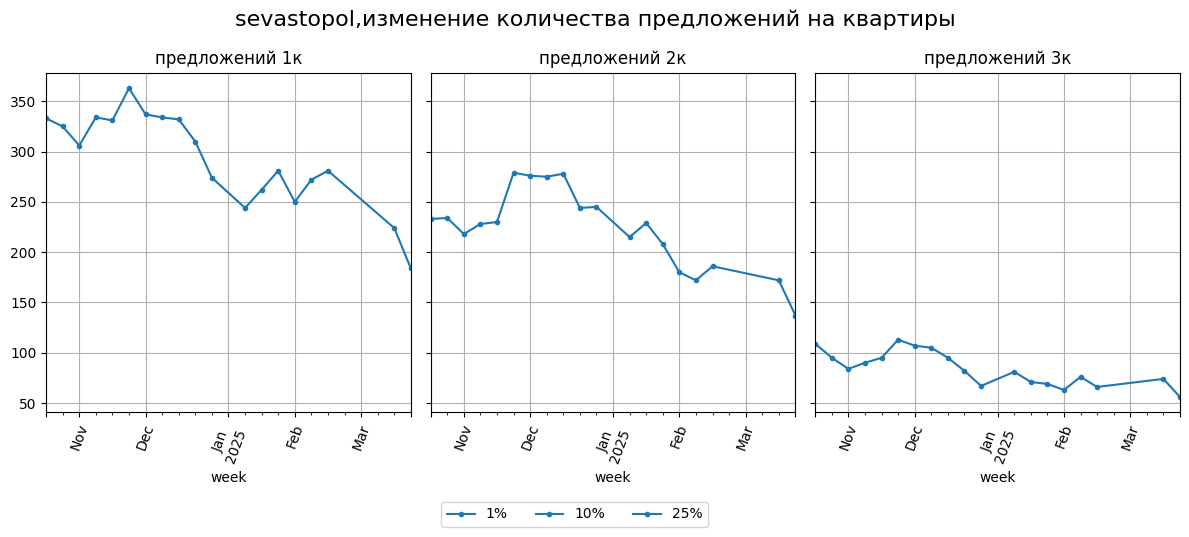

In [33]:
fig, ax = plt.subplots(1,len(sizes),figsize=(12,5), sharey=True )

for i,s in enumerate(sizes): 
    stat.loc[(place,s),'count'].plot(title=f'предложений {s}к', grid=True,ax=ax[i],legend=False, rot=70, style='.-' )   
#     ax[i].set_yticks( np.arange(2, 16, step=1) )


fig.suptitle(f'{place},изменение количества предложений на квартиры', fontsize=16)
fig.legend( labels=cols,frameon=True, ncol=len(cols), bbox_to_anchor=(0.6, 0.01))    
fig.tight_layout()

# актуальная цена

In [34]:
# sorted(gdf['dt'].unique() )

In [35]:
# dt_now = pd.to_datetime('2024-06-17').date()
dt_now = gdf['dt'].max()
display(len(gdf))
gdf_last = gdf[ gdf['dt'] == dt_now ]
display(len(gdf_last))

11414

377

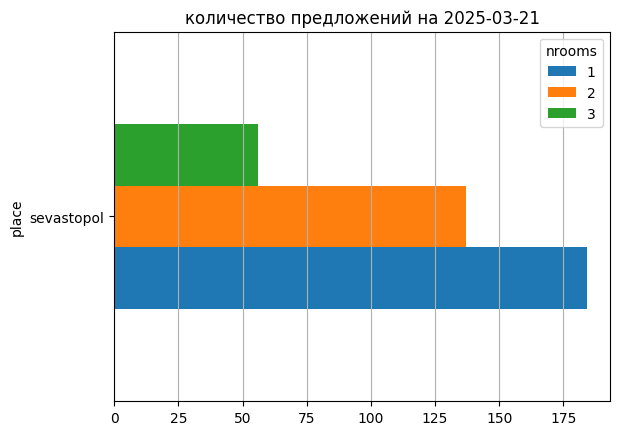

In [36]:
(
gdf_last
.drop_duplicates('url')
.groupby(['nrooms','place'])['url'].count().reset_index()
.pivot(index='place', columns='nrooms', values='url')
.plot.barh(title='количество предложений на '+ str(dt_now))
.grid(axis='x')    
)

In [37]:
(
    gdf_last
    .drop_duplicates('url')
    .groupby(['place','nrooms'])
    ['priceK'].describe(percentiles=percentiles)
)

count  mean    std   min    1%    5%   10%   25%   50%  \
place      nrooms                                                           
sevastopol 1      184.00 25.93   7.35 12.00 14.99 16.00 17.30 20.00 25.00   
           2      137.00 98.66 671.69 10.00 17.36 22.00 25.00 27.00 35.00   
           3       56.00 68.77  29.93 20.00 22.20 31.50 35.00 45.00 60.00   

                    75%    90%    95%     max  
place      nrooms                              
sevastopol 1      30.00  35.00  39.70   55.00  
           2      53.00  70.00  80.00 7900.00  
           3      92.50 120.00 120.00  140.00

In [47]:
q_95 = gdf_last.groupby(['place'])['priceK'].quantile(.95)
display( q_95 )

place
sevastopol   92.00
Name: priceK, dtype: float64

In [48]:
# place = 'sevastopol'
# fig, ax = plt.subplots(figsize=(12,4))
# (
#     gdf_last
#     .drop_duplicates('url')
#     .query(f' (place=="{place}") & (priceK<{q_95[place]}) & (0<nrooms<5) ')
#     .groupby(['nrooms'],observed=True)
#     ['priceK']
#     .plot.kde(legend=True,ax=ax,title=f'{place}', grid=True)   
# )
# ax.set_xticks( np.arange(0, 60, step=5) )
# fig.suptitle(f'распределение цены на аренду квартиры на '+ str( gdf_last['dt'].max() ), fontsize=16)
# fig.tight_layout()

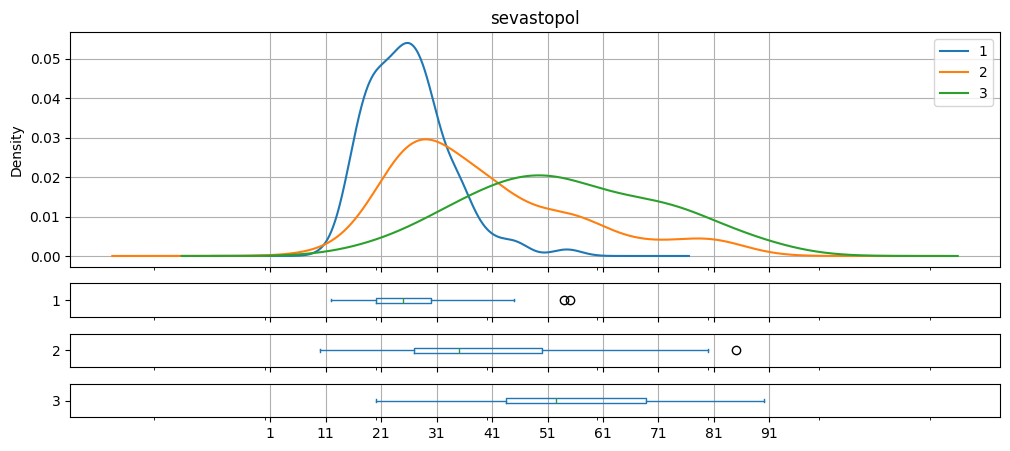

In [66]:
# p = 'sudak'
p = 'sevastopol'

#price_t = 40.
price_t = q_95[p]

fig, ax = plt.subplots(4,1,figsize=(12,5), sharex=True, gridspec_kw={'height_ratios': [7,1,1,1]})
(
    gdf_last
    .drop_duplicates('url')
    .query(f'(place=="{p}")&(priceK<{price_t})')
    .groupby(['nrooms'],observed=True)
    ['priceK'].plot.kde(legend=True,title=f'{p}', grid=True, ax=ax[0])
    # ['priceM'].plot.hist(legend=True,title=f'{p}', grid=True, ax=ax[0],bins=30)
)
ax[0].set_xticks( np.arange(1, 100, step=10) )

for n in range(1,4):
    (
        gdf_last    
        .query(f'(place=="{p}")&(priceK<{price_t})&(nrooms=={n})')
        ['priceK'].plot.box(grid=True, vert=False, ax=ax[n], label=f'{n}')
    )
    ax[n].grid( axis='y')

# цены на карте

In [67]:
import h3
from shapely.geometry import Polygon
from shapely.geometry import MultiPoint

In [68]:
# def cover_grid_hexagonal(gmtr,cell_size=6,crs='EPSG:4326'):
#     polygonise = lambda hex_id: Polygon( h3.h3_to_geo_boundary( hex_id, geo_json=True)  )
#     # hexs = list(h3.polygon_to_cells( gmtr.__geo_interface__, cell_size, geo_json_conformant = True ))
#     hexs = list(h3.polyfill( gmtr.__geo_interface__, cell_size, geo_json_conformant = True ))
#     return gpd.GeoDataFrame({ 'hex_id': hexs,  'geometry': list(map(polygonise, hexs)), },crs=crs,)

In [69]:
# h3.polygon_to_cells?

## Севастополь

In [70]:
# frame_sevastopol = gpd.GeoDataFrame([{ # все предложения
#             'place':'sevastopol', 
#             'geometry':MultiPoint( gdf_last.query('place=="sevastopol"')['geometry'].tolist() ).convex_hull, 
#         }],crs='EPSG:4326')

# # frame_sevastopol.explore()

In [71]:
# grid = cover_grid_hexagonal( frame_sevastopol.geometry.values[0],cell_size=8 )

In [72]:
# q_sev = gdf_last.groupby(['place'])['priceK'].quantile(.85)['sevastopol']
# display( q_sev )

In [73]:
# # медиана цены за квадратный метр (тыс.руб.)

# grid_values = ( 
#     grid
#     .sjoin( 
#         gdf_last
#         .drop_duplicates('url')
#         .query(f'(place=="sevastopol")&(0<nrooms<4) & (priceK<{q_sev})')
#         , how='inner',)
#     .groupby(['hex_id'])
#     ['priceK']
#     .median()
#     .reset_index()
# )
# grid.merge(grid_values,on='hex_id').explore('priceK',cmap='rainbow') #'area_name', legend=True)

# районы Севастополя

In [74]:
# загружаем области поиска
frames_path = 'data/frames/'
frames_index = pd.read_csv(f'{frames_path}/_index.tsv',sep='\t')

swap_coo = lambda coo : [ (c[1],c[0]) for c in coo ]
df2poly = lambda df : Polygon(swap_coo(df.values))

frames = gpd.GeoDataFrame([ 
        { 'area_name':nm, 'geometry': df2poly( pd.read_csv(f'{frames_path}/{f}',header=None) ) } 
        for nm,f in frames_index.values
    ],crs='epsg:4326',)

# display(frames)

In [75]:
display(frames[['area_name']])

,area_name
0,"Севастополь, район Острякова"
1,"Севастополь, парк 60-летия СССР"
2,"Севастополь, Хрусталёва/Хрюкина"
3,"Севастополь, Геловани/Коломийца"
4,"Севастополь, Музыки/Бирюзова"
5,"Севастополь, кр.горка (старый)"
6,"Севастополь, кр.горка (новый)"
7,"Севастополь, Малахов курган"
8,"Севастополь, Благополучный"


In [76]:
frames.explore('area_name', legend=True)

In [77]:
area_name=[
# 'Севастополь, парк 60-летия СССР',
#'Севастополь, Хрусталёва/Хрюкина',
'Севастополь, район Острякова',
# 'Севастополь, Малахов курган',
#'Севастополь, Геловани/Коломийца',
]

In [78]:
# выбираем область
frame_ = frames[frames['area_name'].isin(area_name)]

In [79]:
# фильтруем данные по области
gdf_last_local = gdf_last.drop_duplicates('url').sjoin( frame_, how='inner', predicate='within') 
gdf_last_local[['title','priceK','address','geometry']].explore( legend=False)

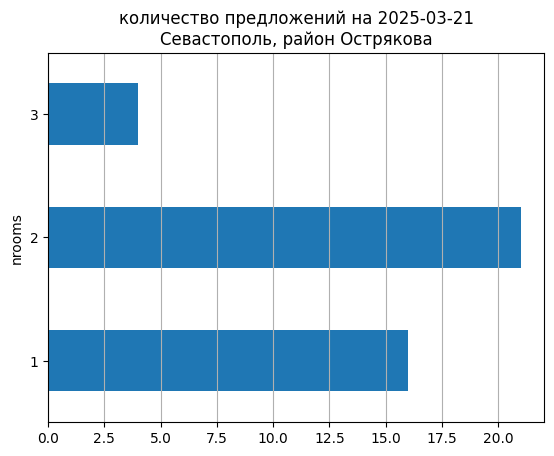

In [80]:
(
    gdf_last_local
    .drop_duplicates('url')
    .groupby(['nrooms'])['url'].count()
    .plot.barh(title='количество предложений на '+ str( dt_now ) + '\n' + ' / '.join(area_name) )
    .grid(axis='x')   
)

In [81]:
# gdf_last_local

In [82]:
(
    gdf_last_local
    .groupby(['nrooms'],observed=True)['priceK']
    .describe(percentiles=percentiles)
    .fillna(0.)
    .astype(int)
)

,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,max
nrooms,,,,,,,,,,,,,
1,16,26,5,18,18,18,20,22,25,30,32,35,35
2,21,410,1716,25,25,25,25,27,32,40,58,70,7900
3,4,41,9,32,32,32,32,34,42,50,50,50,50


In [85]:
q_95 = gdf_last_local['priceK'].quantile(.95)
q_95

np.float64(58.888)

In [ ]:
# fig, ax = plt.subplots(figsize=(7,3) )
# (
#     gdf_last_local
#      #.query(f'(priceK<{q_95})')
#     .query('nrooms<3')
#     # .drop_duplicates('url')
#     .groupby(['nrooms'],observed=True)
#     ['priceK'].plot.kde(legend=True,ax=ax,title='/'.join(area_name), grid=True)   
# )

# ax.set_xticks( np.arange(15, 60, step=2) )

# fig.suptitle(f'распределение цены на квартиры на '+ str( dt_now ), fontsize=16)
# fig.tight_layout()

Text(0.5, 0.98, 'распределение цены на квартиры на 2025-03-21')

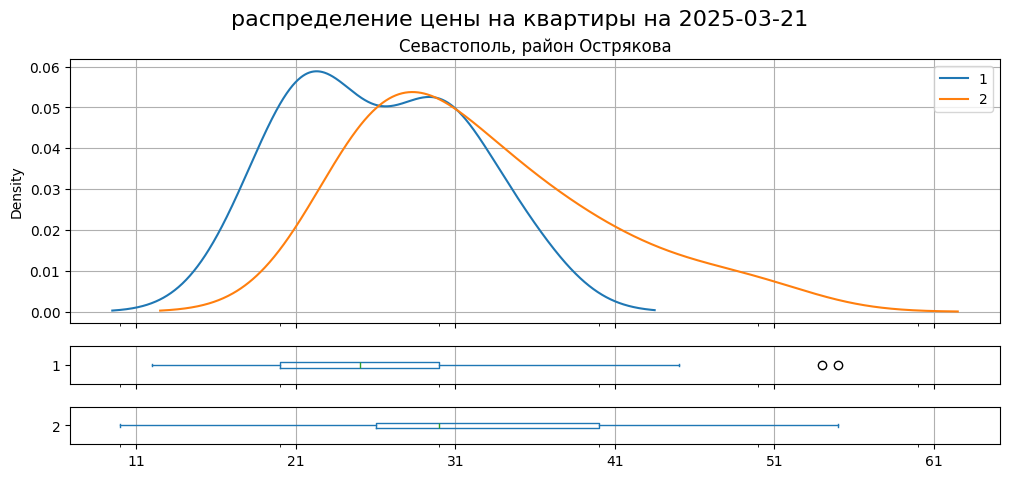

In [86]:
# p = 'sevastopol'
fig, ax = plt.subplots(3,1,figsize=(12,5), sharex=True, gridspec_kw={'height_ratios': [7,1,1]})
(
    gdf_last_local
    .drop_duplicates('url')
    .query(f'(place=="{p}")&(priceK<{q_95})&(nrooms<3)')
    #.query(f'(place=="{p}")&(nrooms<3)')
    .groupby(['nrooms'],observed=True)
    ['priceK'].plot.kde(legend=True, grid=True, ax=ax[0],title='/'.join(area_name))
    # ['priceM'].plot.hist(legend=True,title=f'{p}', grid=True, ax=ax[0],bins=30)
)
ax[0].set_xticks( np.arange(1, 125, step=10) )

for n in range(1,3):
    (
        gdf_last    
        .query(f'(place=="{p}")&(priceK<{q_95})&(nrooms=={n})')
        # .query(f'(place=="{p}")&(nrooms=={n})')
        ['priceK'].plot.box(grid=True, vert=False, ax=ax[n], label=f'{n}')
    )
    ax[n].grid( axis='y')
fig.suptitle(f'распределение цены на квартиры на '+ str( dt_now ), fontsize=16)
# fig.tight_layout()

----

In [87]:
# изменение цены по району
gdf_local = gdf.sjoin( frame_, how='inner', predicate='within') 

In [88]:
percentiles=[.01,.05,.1,.25,.5,.75,.9]
# stat = gdf_local.groupby(['nrooms','month'],observed=True)['priceM'].describe(percentiles=percentiles)
stat = gdf_local.groupby(['nrooms','week'],observed=True)['priceK'].describe(percentiles=percentiles)
# display( stat )

In [89]:
stat[['count']].describe(percentiles).T

,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,max
count,57.00,18.65,8.19,4.00,4.56,6.00,7.60,12.00,18.00,25.00,30.40,36.00


In [90]:
display(len(stat))
stat_ = stat.query('count>12')
display(len(stat_))

57

41

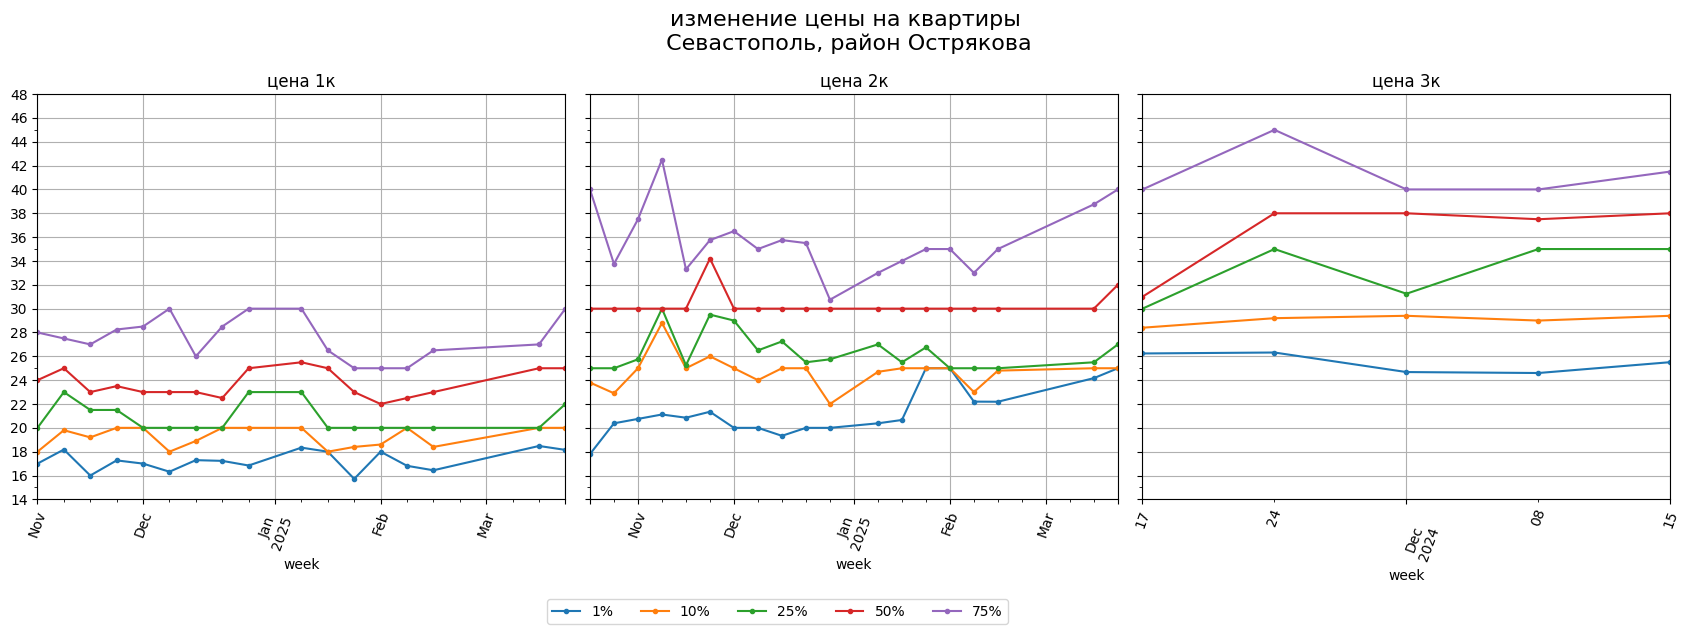

In [91]:
fig, ax = plt.subplots(1,len(sizes),figsize=(17,6), sharey=True )

for i,s in enumerate(sizes): 
    stat_.loc[(s),cols].plot(title=f'цена {s}к', grid=True,ax=ax[i],legend=False, rot=70, style='.-' )   
    ax[i].set_yticks( np.arange(14, 50, step=2) )

fig.suptitle(f'изменение цены на квартиры\n {'/'.join(area_name)}', fontsize=16)
fig.legend( labels=cols,frameon=True, ncol=len(cols), bbox_to_anchor=(0.6, 0.01))    
fig.tight_layout()

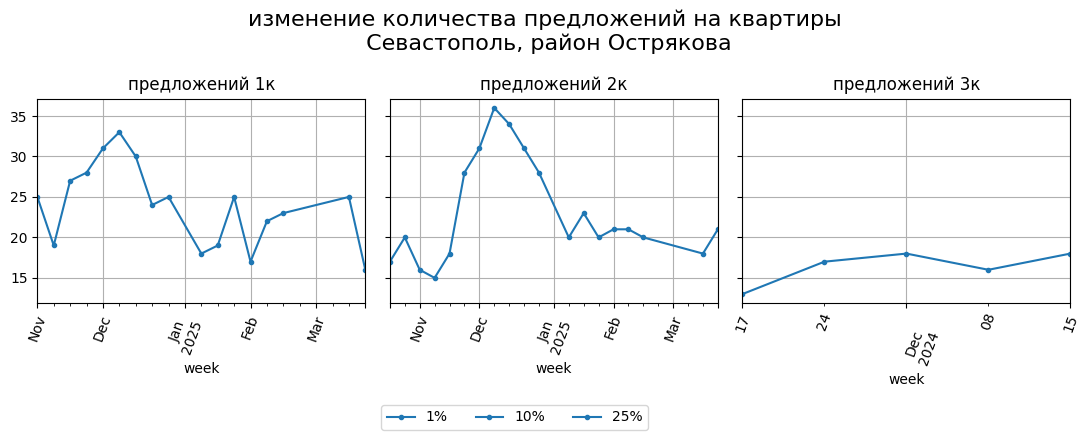

In [92]:
fig, ax = plt.subplots(1,len(sizes),figsize=(11,4), sharey=True )

for i,s in enumerate(sizes): 
    stat_.loc[(s),'count'].plot(title=f'предложений {s}к', grid=True,ax=ax[i],legend=False, rot=70, style='.-' )   

fig.suptitle(f'изменение количества предложений на квартиры\n {'/'.join(area_name)}', fontsize=16)

fig.legend( labels=cols,frameon=True, ncol=len(cols), bbox_to_anchor=(0.6, 0.01))    
fig.tight_layout()